In [18]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from scipy.stats import norm, skew #for some statistics
from scipy import stats #qqplot
import statsmodels.api as sm
from matplotlib import rcParams
import matplotlib.pyplot as plt

In [19]:
data=pd.read_csv('/kaggle/input/productdemandforecasting/Historical Product Demand.csv')
prod=pd.unique(data['Product_Code']).tolist()
cate=pd.unique(data['Product_Category']).tolist()

In [20]:
data['Order_Demand'] = data['Order_Demand'].str.replace('(',"")
data['Order_Demand'] = data['Order_Demand'].str.replace(')',"")
data['Order_Demand'] = data['Order_Demand'].astype('int64')

In [21]:
print(len(prod),len(cate))
data.head()

2160 33


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [22]:
data.columns

Index(['Product_Code', 'Warehouse', 'Product_Category', 'Date',
       'Order_Demand'],
      dtype='object')

In [23]:
#np.random.uniform(low=1.3, high=9.2, size=(33,))

In [24]:
temperature=[7, 2, 6, 2, 6, 7, 3, 1, 6, 6, 4, 3, 7, 6, 4, 4, 5, 7, 3, 7, 5, 7,5, 2, 5, 4, 1, 3, 3, 3, 4, 2, 3]
food=['Dairy_products','baked_products','sugar_baked','eggs','meat','poultry','fish','flour','seafood','legumes ','cooked_food','cooked_vegetables','cooked_meat','leftovers','other_fruits','other_vegetable','Citrus','Stone_fruit','Tropical','peas','berries','melons','green_vegetables','Cruciferous','acidic_fruits','Marrow','root','allium','Soy Products','fresh_drinks','processed_food','desserts','bevarages']
food.sort()
for i in range(data.shape[1]):
    data=data.replace(to_replace=cate[i],value=food[i])
'''temp=pd.DataFrame(data=data['Product_Category'],columns='Temperature')
for i in range(data.shape[1]):
    temp=temp.replace(to_replace=food[i],value=temperature[i])
data=data.join(temp)'''

"temp=pd.DataFrame(data=data['Product_Category'],columns='Temperature')\nfor i in range(data.shape[1]):\n    temp=temp.replace(to_replace=food[i],value=temperature[i])\ndata=data.join(temp)"

In [25]:
data['year']= pd.DatetimeIndex(data['Date']).year
data['month']= pd.DatetimeIndex(data['Date']).month
data['day']= pd.DatetimeIndex(data['Date']).day
data.drop('Date',axis=1,inplace=True)


In [26]:
y=pd.DataFrame(data['Order_Demand'])
data.drop('Order_Demand',axis=1,inplace=True)
x_train,x_valid,y_train,y_valid=train_test_split(data,y,test_size=0.2,random_state=2)

In [27]:
label=LabelEncoder()
cat=['Product_Code', 'Warehouse', 'Product_Category']
train_temp1=x_train.copy()
valid_temp1=x_valid.copy()
for col in cat:
    train_temp1[col]=pd.DataFrame(label.fit_transform(train_temp1[col]))
    valid_temp1[col]=pd.DataFrame(label.fit_transform(valid_temp1[col]))
x_train=train_temp1.copy()
x_valid=valid_temp1.copy()

In [28]:
'''label=LabelEncoder()
df=data.copy()
for col in cat:
    df[col]=pd.DataFrame(label.fit_transform(df[col]))
impute=SimpleImputer(strategy='median')
df=pd.DataFrame(impute.fit_transform(df))
df.columns=data.columns'''

"label=LabelEncoder()\ndf=data.copy()\nfor col in cat:\n    df[col]=pd.DataFrame(label.fit_transform(df[col]))\nimpute=SimpleImputer(strategy='median')\ndf=pd.DataFrame(impute.fit_transform(df))\ndf.columns=data.columns"

In [29]:
impute=SimpleImputer(strategy='median')
train=pd.DataFrame(impute.fit_transform(x_train))
valid=pd.DataFrame(impute.fit_transform(x_valid))
train.columns=x_train.columns
valid.columns=x_valid.columns

In [30]:
sam_y= y_train['Order_Demand'].head(100)
sam_x=train.head(100)

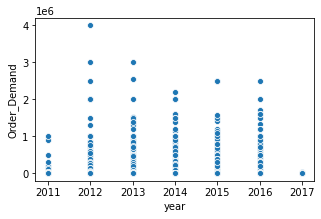

In [31]:
import seaborn as sns
rcParams['figure.figsize'] = 5,3
sns.scatterplot(x=x_train['year'],y=y_train['Order_Demand'])

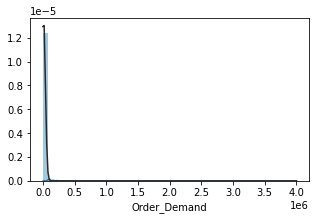

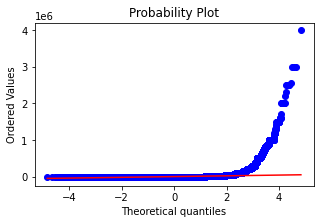

In [32]:
# figure size in inches
rcParams['figure.figsize'] = 5,3
sns.distplot(y['Order_Demand'], fit=norm)
#Get the QQ-plot
fig = plt.figure()
res = stats.probplot(y['Order_Demand'], plot=plt)
plt.show()

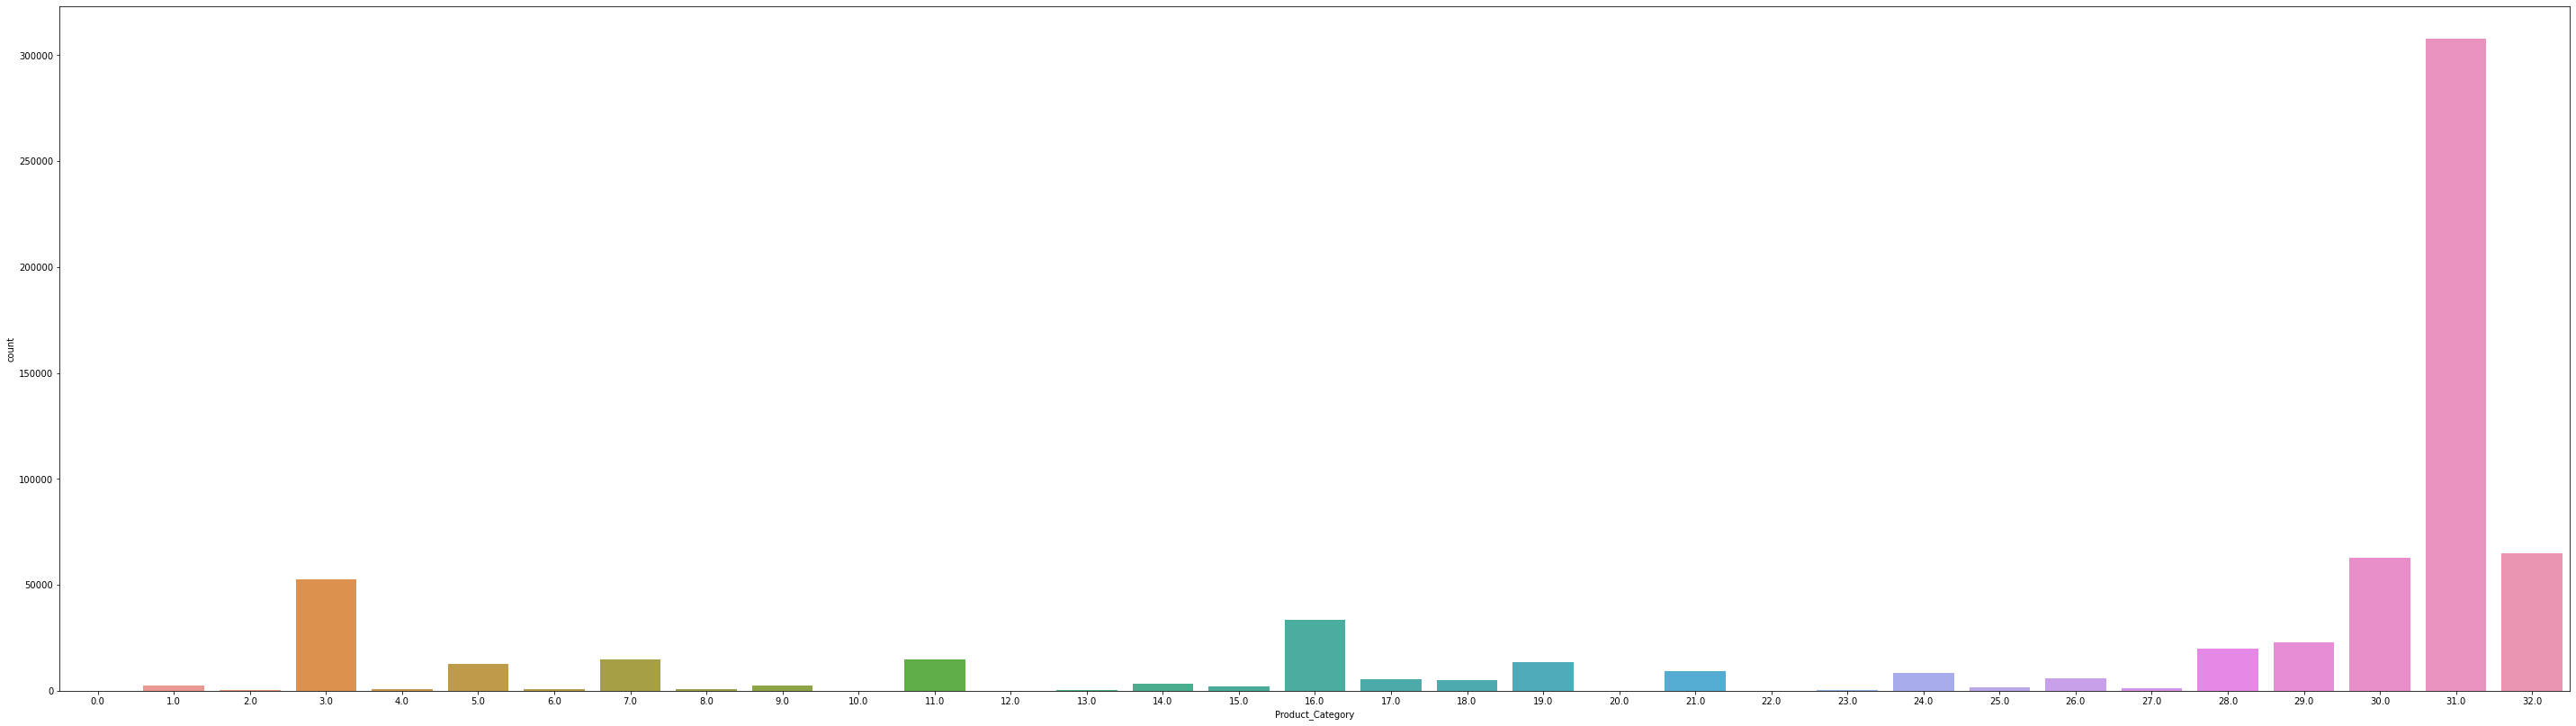

In [33]:
rcParams['figure.figsize'] = 50,14
sns.countplot(x_train['Product_Category'].sort_values(ascending = True))

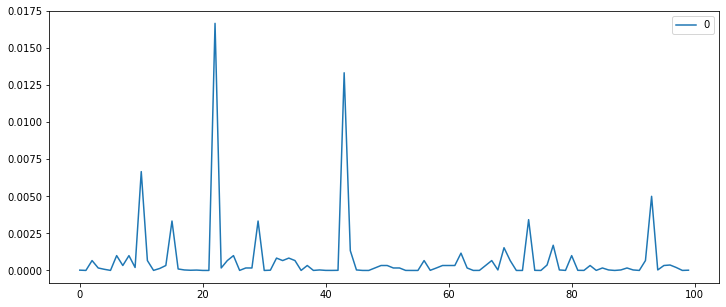

In [41]:
y_valid.head(100).plot(figsize=(12,5))
plt.show()

In [35]:
from sklearn import preprocessing
min_max_scaler=preprocessing.MinMaxScaler()
x_train= pd.DataFrame(min_max_scaler.fit_transform(train))
x_valid= pd.DataFrame(min_max_scaler.fit_transform(valid))
y_train= pd.DataFrame(min_max_scaler.fit_transform(y_train))
y_valid= pd.DataFrame(min_max_scaler.fit_transform(y_valid))

In [36]:
from sklearn.linear_model import LinearRegression
model=LinearRegression()
model.fit(x_train,y_train)
prediction=model.predict(x_valid)
model.score(x_valid,y_valid)#worst performance

-0.001686634043173596

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = sm.tsa.statespace.SARIMAX(y_train(1000),
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

In [38]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0688      0.000    171.679      0.000       0.068       0.070
ma.L1         -0.7671      0.000  -2420.511      0.000      -0.768      -0.766
ar.S.L12      -0.5119      0.000  -2580.013      0.000      -0.512      -0.511
sigma2      2.409e+09   1.36e-13   1.77e+22      0.000    2.41e+09    2.41e+09


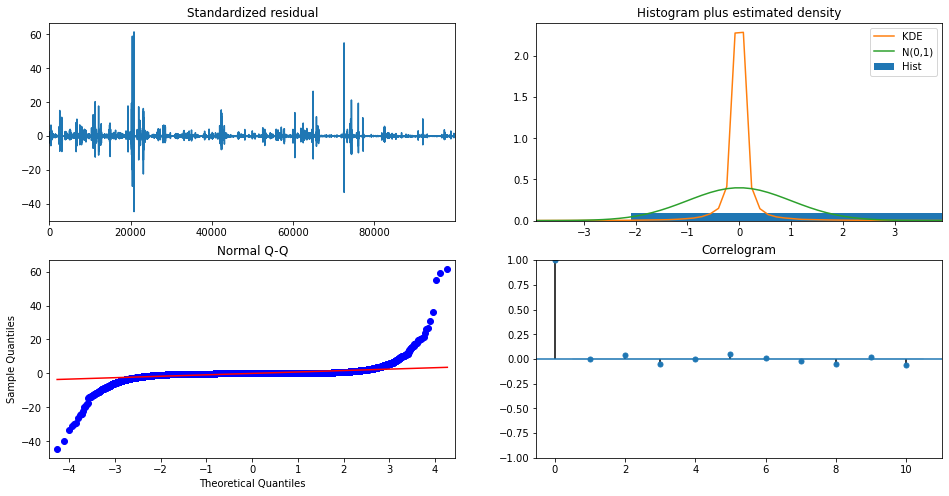

In [39]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [47]:
pred = results.get_prediction(start=pd.to_datetime('2014-05-01').month, dynamic=False) 
pred_ci = pred.conf_int()

In [50]:

ax = y_train['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()

TypeError: cannot do slice indexing on <class 'pandas.core.indexes.range.RangeIndex'> with these indexers [2013] of <class 'str'>

In [ ]:
#output is the graph in grey area By plotting the x axis(date) against y axis(demand) we can get the predicted demand